In [34]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from shapely import Point

## 随机点

In [2]:
def generate_random_points(polygon, num_points):
    '''
    polygon: 你输入的矢量文件
    num_points: 你需要产生的随机点数量
    '''
    # 存储点
    random_points = []
    while len(random_points) < num_points:
        # 生成随机坐标
        min_x, min_y, max_x, max_y = polygon.total_bounds  # 注意根据你的多边形数据格式进行更改
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))

        # 检查点是否在多边形内
        if polygon.contains(random_point)[0] and random_point not in random_points:  # 注意根据你的多边形数据格式进行更改
        # if polygon.contains(random_point)[0]:  # 注意根据你的多边形数据格式进行更改
            random_points.append(random_point)
            
    # 创建 GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=random_points, crs=polygon.crs)
    gdf['FID'] = gdf.index
    
    # 将得到的点作为结果返回
    return gdf

In [3]:
gdf = gpd.read_file('data/2000_2020/长三角一体化示范区/长三角一体化示范区范围.shp')

In [4]:
points = generate_random_points(gdf, 3000)

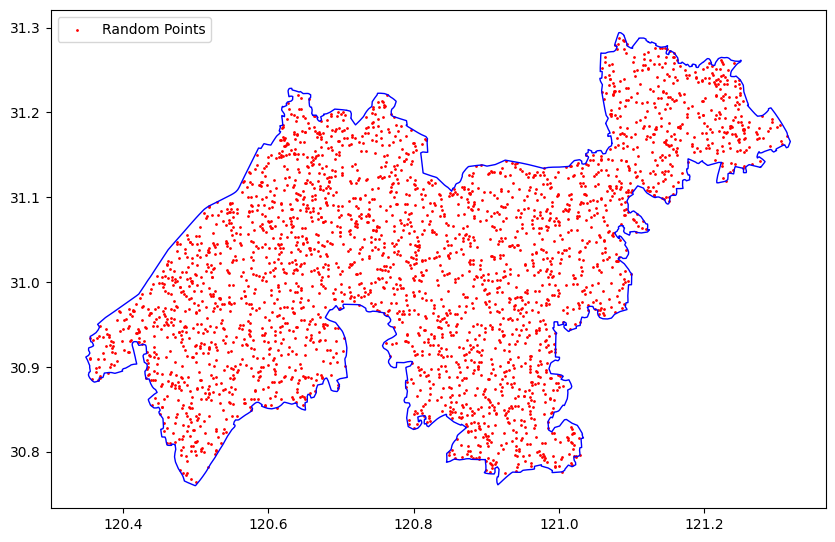

In [5]:
ax = points.plot(figsize=(10,8), color='red', markersize=1, label='Random Points')
gdf.plot(ax=ax, facecolor='none', edgecolor='blue')
plt.legend(loc='upper left')
plt.show()

In [6]:
points.to_file('data/2000_2020/长三角一体化示范区/研究区随机点.shp')

In [12]:
index_ = ['lst_','ndbsi_','ndvi_','resi_','wet_']
years = [2000, 2010, 2020]

## 提取指数

In [1]:
# import os
# os.environ["PATH"] = "D:\\ProgramData\\Anaconda3\\envs_1\\py310\\Lib\\site-packages\\osgeo;D:\\ProgramData\\Anaconda3\\envs_1\\py310\\Lib\\site-packages\\rasterio;"+os.environ["PATH"]
# os.environ["PYTHONPATH"] = "D:\\anaconda3\\envs\\py39_sif\\Lib\\site-packages\\osgeo;D:\\anaconda3\\envs\\py39_sif\\Lib\\site-packages\\rasterio;"+os.environ["PATH"]

In [3]:
from osgeo import gdal, ogr

In [41]:
def raster_plot(dataset, drop_na=True, cmap=None):
    band = dataset.GetRasterBand(1).ReadAsArray().astype(float)
    if drop_na: 
        array = np.ma.masked_where(band==get_nodatavalue(dataset), band)  # 去除NAN值
        # array = np.ma.masked_where(array==1, array)
    else: 
        array = band
    plt.imshow(array, cmap=cmap)
    plt.axis('off')
    plt.show()

# 获取无效值
def get_nodatavalue(dataset):
    band = dataset.GetRasterBand(1)
    return band.GetNoDataValue()

# 提取对应点的栅格值
def get_value_in_point(tif_file, shp_file):
    # 打开.tif文件
    tif_dataset = gdal.Open(tif_file)
    if tif_dataset is None:
        print("无法打开.tif文件")
        return
    # 打开.shp文件
    shp_datasource = ogr.Open(shp_file)
    if shp_datasource is None:
        print("无法打开.shp文件")
        return

    # 获取.shp图层
    shp_layer = shp_datasource.GetLayer()
    shp_layer.ResetReading()

    # 获取.tif文件的地理参考信息
    transform = tif_dataset.GetGeoTransform()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = transform[5]

    # 获取FID字段索引
    fid_index = shp_layer.GetLayerDefn().GetFieldIndex('FID')

    # 存结果
    fids = []
    pixel_values = []
    # 遍历.shp文件中的要素
    for feature in shp_layer:
        fid = feature.GetField(fid_index)
        geom = feature.GetGeometryRef()
        x = geom.GetX()
        y = geom.GetY()

        # 将.shp中的点转换为.tif中的像素坐标
        xOffset = int((x - xOrigin) / pixelWidth)
        yOffset = int((y - yOrigin) / pixelHeight)

        # 读取.tif文件中的像素值
        band = tif_dataset.GetRasterBand(1)  # 假设.tif文件只有一个波段
        pixel_value = band.ReadAsArray(xOffset, yOffset, 1, 1)[0, 0]
        fids.append(fid)
        pixel_values.append(pixel_value)
        
    # 关闭数据集
    tif_dataset = None
    shp_datasource = None
    
    return pd.DataFrame(data={'FID':fids, 'value':pixel_values})

In [25]:
path_tif = f'data/2000_2020/2000/{index_[0]}{years[0]}g.tif'
path_shp = 'data/2000_2020/长三角一体化示范区/研究区随机点.shp'

tif_ds = gdal.Open(path_tif)  # tif
point_ds = ogr.Open(path_shp)  # shp
point_layer = point_ds.GetLayer()

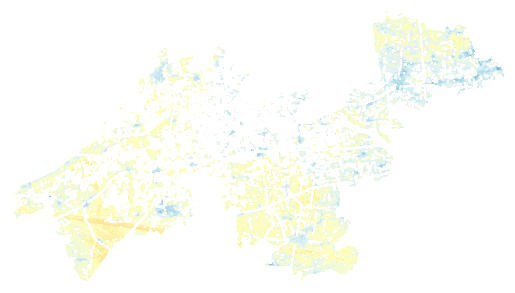

In [29]:
raster_plot(tif_ds, True, cmap='RdYlBu')

In [42]:
df = get_value_in_point(path_tif, path_shp)
df

,FID,value
0,0,4.961056e-01
1,1,5.721943e-01
2,2,5.410262e-01
3,3,5.117860e-01
4,4,-3.402823e+38
...,...,...
2995,2995,5.076089e-01
2996,2996,4.971018e-01
2997,2997,4.873658e-01
2998,2998,5.523688e-01
